# 1.Imports 

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

2023-11-13 00:20:00.868619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 00:20:00.868652: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 00:20:00.868683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 00:20:00.875401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(123)
np.random.seed(123)

# 2.Loading data

In [3]:
base_dir='skin-disease-datasaet/train_set' 
base_dir2='skin-disease-datasaet/test_set'
IMAGE_SIZE=256
BATCH_SIZE=8

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-13 00:20:02.341715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:20:02.346583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:20:02.346760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
#pre=processing
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    

    )

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
 
)

train_generator=train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
 
)

test_generator=test_datagen.flow_from_directory(
    base_dir2,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False, 
)

Found 924 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


# 3.CNN Architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

dnn = Sequential()
dnn.add(Flatten(input_shape=(256, 256, 3)))
    
dnn.add(Dense(1024, activation='relu'))
dnn.add(BatchNormalization())
dnn.add(Dropout(0.2))     
dnn.add(Dense(512, activation='relu'))
dnn.add(BatchNormalization())    
dnn.add(Dense(256, activation='relu'))
dnn.add(BatchNormalization())
dnn.add(Dense(128, activation='relu'))
dnn.add(BatchNormalization())
dnn.add(Dense(64, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(8, activation='softmax'))

dnn.summary()

2023-11-13 00:20:02.417666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:20:02.417868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:20:02.418022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [10]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    predicted_positives = tf.math.reduce_sum(tf.math.round(y_pred))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    actual_positives = tf.math.reduce_sum(y_true)
    return true_positives / (actual_positives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

# 4. training the model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "dnn.h5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

dnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1_score]
)

hist = dnn.fit(train_generator, epochs=500, validation_data=test_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/500


2023-11-13 00:20:03.903138: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 00:20:04.830615: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fabb8f0c310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 00:20:04.830636: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-13 00:20:04.834351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 00:20:04.845789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 00:20:04.919451: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/116 [============================>.] - ETA: 0s - loss: 2.1292 - accuracy: 0.1692 - precision: 0.0174 - recall: 0.0022 - f1_score: 0.0039
Epoch 1: saving model to dnn.h5


/home/zeyd/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-11-13 00:20:10.959846: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 805306368 exceeds 10% of free system memory.
2023-11-13 00:20:12.244363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 805306368 exceeds 10% of free system memory.
2023-11-13 00:20:12.766084: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 805306368 exceeds 10% of free system memory.
2023-11-13 00:20:14.963645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 805306368 exceeds 10% of free system memory.
2023-11-13 00:20:15.490430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 805306368 exceeds 10% of free syste

116/116 [==============================] - 13s 85ms/step - loss: 2.1245 - accuracy: 0.1721 - precision: 0.0172 - recall: 0.0022 - f1_score: 0.0038 - val_loss: 5.9092 - val_accuracy: 0.1459 - val_precision: 0.1458 - val_recall: 0.1250 - val_f1_score: 0.1344
Epoch 2/500
115/116 [============================>.] - ETA: 0s - loss: 2.0365 - accuracy: 0.2096 - precision: 0.0174 - recall: 0.0022 - f1_score: 0.0039
Epoch 2: saving model to dnn.h5
116/116 [==============================] - 10s 84ms/step - loss: 2.0367 - accuracy: 0.2089 - precision: 0.0172 - recall: 0.0022 - f1_score: 0.0038 - val_loss: 2.0194 - val_accuracy: 0.2361 - val_precision: 0.1417 - val_recall: 0.0625 - val_f1_score: 0.0856
Epoch 3/500
115/116 [============================>.] - ETA: 0s - loss: 1.9797 - accuracy: 0.2413 - precision: 0.1043 - recall: 0.0130 - f1_score: 0.0232
Epoch 3: saving model to dnn.h5
116/116 [==============================] - 10s 84ms/step - loss: 1.9773 - accuracy: 0.2413 - precision: 0.1034 - rec

In [12]:
last_epoch = len(hist.history['loss'])

metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']

for metric_name in metric_names:
    last_value = hist.history[metric_name][last_epoch - 1]
    print(f"{metric_name}: {last_value:.4f}")

loss: 1.4342
accuracy: 0.4816
precision: 0.6866
recall: 0.2575
f1_score: 0.3638


In [13]:
last_epoch = len(hist.history['loss']) - 1  

metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']

for metric_name in metric_names:
    training_value = hist.history[metric_name][last_epoch]
    validation_value = hist.history[f'val_{metric_name}'][last_epoch]
    print(f"{metric_name}:")
    print(f"  Training: {training_value:.4f}")
    print(f"  Validation: {validation_value:.4f}")

loss:
  Training: 1.4342
  Validation: 1.8039
accuracy:
  Training: 0.4816
  Validation: 0.4163
precision:
  Training: 0.6866
  Validation: 0.4844
recall:
  Training: 0.2575
  Validation: 0.2125
f1_score:
  Training: 0.3638
  Validation: 0.2740


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = dnn.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.labels


confusion = confusion_matrix(y_true, y_pred)


print("Confusion Matrix:")
print(confusion)


report = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:")
print(report)


30/30 [==============================] - 0s 10ms/step
Confusion Matrix:
[[18  1  2  5  1  3  1  2]
 [ 1  1  0  6  6  1  3  2]
 [ 2  0 10  7  4  1  3  5]
 [ 9  0  3 15  3  0  2  1]
 [ 5  1  4  2  9  1  0  1]
 [ 8  1  3  1  1  7  3  1]
 [ 8  0  0  2  0  4 20  0]
 [ 5  3  3  3  7  1  4  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.55      0.40        33
           1       0.14      0.05      0.07        20
           2       0.40      0.31      0.35        32
           3       0.37      0.45      0.41        33
           4       0.29      0.39      0.33        23
           5       0.39      0.28      0.33        25
           6       0.56      0.59      0.57        34
           7       0.37      0.21      0.27        33

    accuracy                           0.37       233
   macro avg       0.35      0.35      0.34       233
weighted avg       0.37      0.37      0.36       233



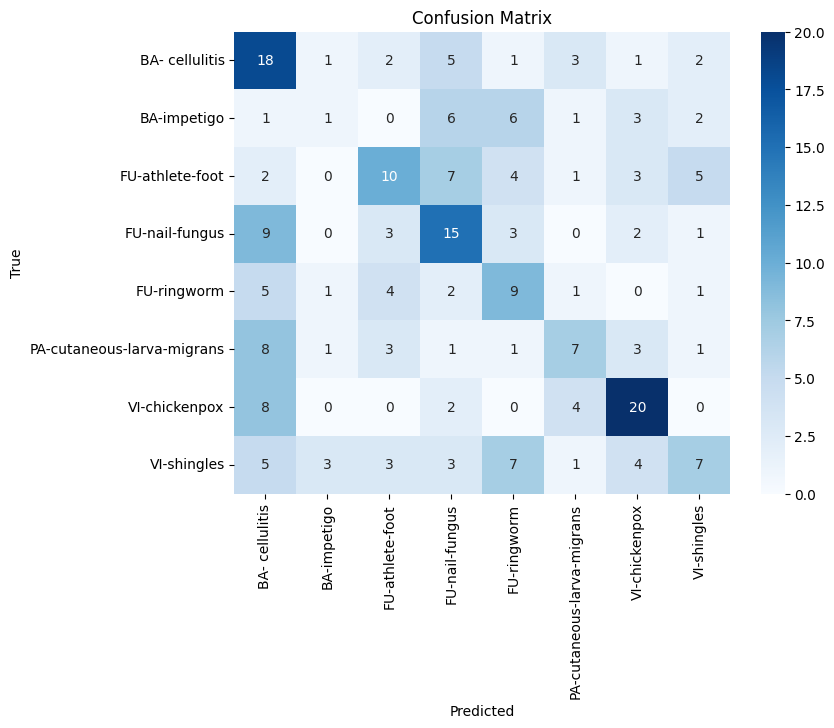

In [15]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from matplotlib import pyplot as plt

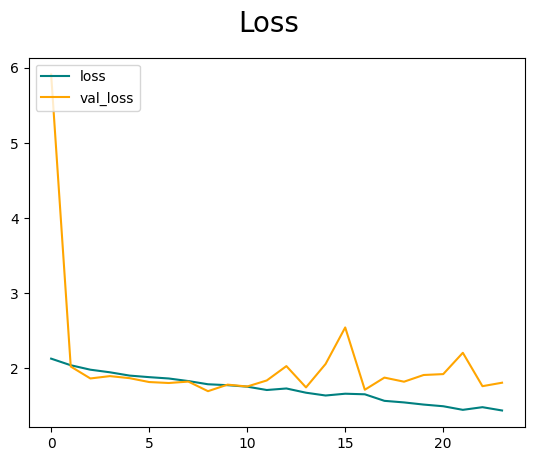

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

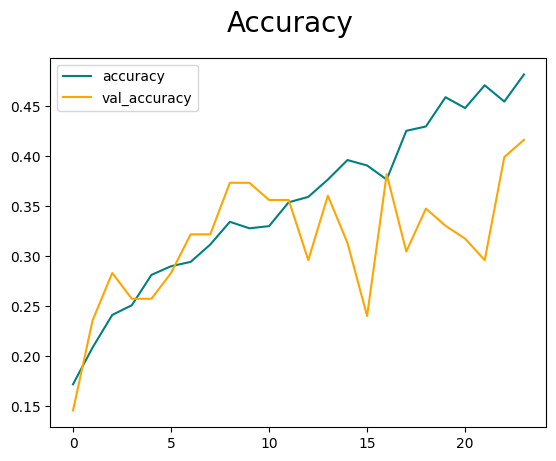

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()